In [1]:
from s4 import S4D 

import os
from lava.utils.system import Loihi2
loihi2_is_available = Loihi2.is_loihi2_available
if loihi2_is_available:
    # Enable SLURM, the workload manager used to distribute Loihi2 resources to users
    os.environ['SLURM'] = '1'
    os.environ['PARTITION'] = "kp"
    os.environ['LOIHI_GEN'] = "N3B3"
import numpy as np
from lava.proc.sdn.process import SigmaDelta, Sigma
from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter
import matplotlib.pyplot as plt
from src.lava.lib.dl.slayer.state_space_models.s4 import S4D
import torch
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg, Loihi2SimCfg
from lava.proc.dense.process import Dense
from lava.proc.sdn.process import ActivationMode
from lava.proc.s4d.process import SigmaS4dDelta, S4d
from lava.proc.sparse.process import Sparse
from lava.proc.spike_integrator.process import SpikeIntegrator
import random

# S4d
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.
CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [2]:
model_dim = 1
d_states = 2

model = S4D(d_model=model_dim,
            d_state=d_states,
            dropout=False,
            transposed=True,
            quantize = False,
            lr=None,
            skip=False,
            activation=None,
            is_real=False)
model = model.to('cpu')
model.eval()

model.setup_step()

n_steps = 1000 # sequence length
inp_exp = 13
inp = (torch.rand(1, model_dim, n_steps) * 2** inp_exp).int().float()

def example_run(on_chip=True):
    # Test just sigma-delta on chip
    state_exp = 6
    numpy_inp = np.asarray(inp)[0]

   
    A = model.layer.kernel.dA.detach().numpy()
    B = model.layer.kernel.dB.detach().numpy()
    C = model.layer.kernel.dC.detach().numpy()
 

    kron_matrix = np.kron(np.eye(model_dim), np.ones((1, )))

    spiker = SourceBuffer(data=numpy_inp)
    dense_1 = Sparse(weights=kron_matrix.T, weight_exp=6, num_message_bits=24)
    neuron = S4d(shape=((model_dim * 1,)), s4_exp = 12,               # hard coded to shift by 6!!!
                        a=A.flatten().reshape((model_dim * 1,)),
                        b=B.flatten().reshape((model_dim * 1,)),
                        c=C.flatten().reshape((model_dim * 1,)))
    relay = SpikeIntegrator(shape=(model_dim,), q_scale=1/2**6, q_exp=6)
    dense_2 = Sparse(weights=kron_matrix, num_message_bits=24, weight_exp=6)
    inp_adapter = PyToNxAdapter(shape=(1,), num_message_bits=24)
    out_adapter = NxToPyAdapter(shape=(1,), num_message_bits=24)
    receiver = SinkBuffer(buffer=n_steps, shape=(model_dim,))

    if on_chip: 
        spiker.s_out.connect(inp_adapter.inp)
        inp_adapter.out.connect(dense_1.s_in)
        dense_1.a_out.connect(neuron.a_in)
        neuron.s_out.connect(dense_2.s_in)
        dense_2.a_out.connect(relay.a_in)
        relay.s_out.connect(out_adapter.inp)
        out_adapter.out.connect(receiver.a_in)
        run_cfg = Loihi2HwCfg()
    else:
    # Connected input -> Dense -> Delta -> neuron -> Dense -> Sigma -> Dense -> Output
        spiker.s_out.connect(dense_1.s_in)
        dense_1.a_out.connect(neuron.a_in)
        neuron.s_out.connect(dense_2.s_in)
        dense_2.a_out.connect(receiver.a_in)
        run_cfg = Loihi2SimCfg()

    neuron.run(
                condition=RunSteps(num_steps=n_steps), run_cfg=run_cfg
            )
    received_data_hw = receiver.data.get()
    received_data_hw = received_data_hw.T
    neuron.stop()
         
    return received_data_hw

end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.01%|  12.50%|   0.02%|   0.01%|   0.01%|   0.00%|   0.03%|       1|
|   0.01%|  12.50%|   0.05%|   0.01%|   0.01%|   0.00%|   0.03%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       2|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.lava.lava-loihi/src/lava/proc/s4d/ncmodels.py:164: ComplexWarning: Casting complex values to real discards the imaginary part
  self.a.var.init = (self.a.var.get() * 2**s4_exp).astype(int)
/home/sveamari/lava_dev/frameworks.ai.lava.lava-loihi/src/lava/proc/s4d/ncmodels.py:165: ComplexWarning: Casting complex values to real discards the imaginary part
  self.b.var.init = (self.b.var.get() * 2**s4_exp).astype(int)
/home/sveamari/lava_dev/frameworks.ai.lava.lava-loihi/src/lava/proc/s4d/ncmodels.py:166: ComplexWarning: Casting complex values to real discards the imaginary part
  self.c.var.init = (self.c.var.get() * 2**s4_exp).astype(int)


hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
h

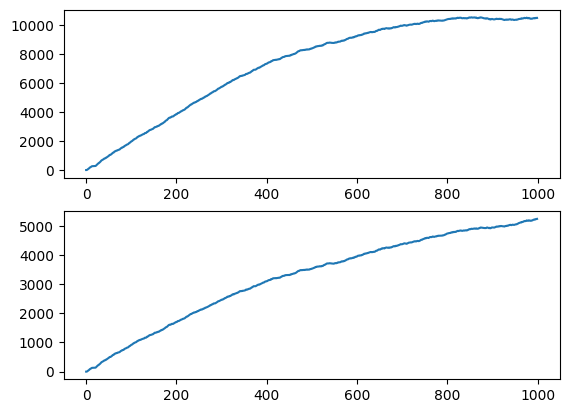

In [3]:
out_hw = example_run(on_chip=True)
out_sim = example_run(on_chip=False)
fix, ax =  plt.subplots(2, 1)
ax[0].plot(out_sim)
ax[1].plot(out_hw)

In [4]:
2**6 * 800

51200

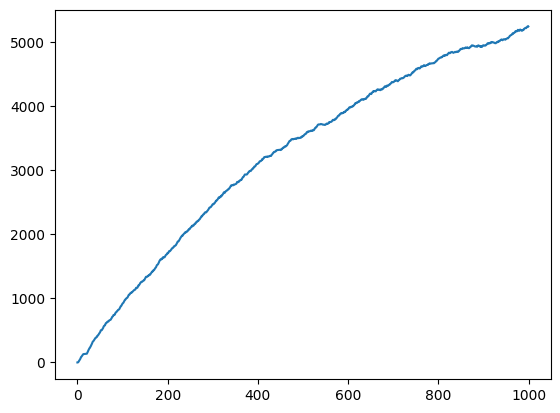

In [5]:
plt.plot(out_hw)

torch.set_printoptions(precision=32)
out = model(inp)[0].detach().numpy().T
out_hw = example_run()
print(out[:-2])
print(out_hw[2:])
print(out[:-2] - out_hw[2:])

# complex example number torch
state = model.default_state(1)

for t in range(1000):
    out, state = model.step(inp[:, :, t], state)
    print(out.detach())
#out[:-2]
#out_hw[2:]